# Introdução

Nesse projeto o objetivo é criar um modelo para classificação de Churn de Clientes para uma empresa de telecomunicações...
Os dados são desbalanceados e necessitam de um tratamento adequado para serem submetidos aos algoritmos...
Os parâmetros precisam ser ajustados de forma a maximizar o balanceamento do modelo e o acerto das classificações, 
pois é importante que o modelo não priorize apenas uma classe, seja ela sim ou não...
Por isso irei utilizar força bruta para ajustar os modelos com os melhores parâmetros possíveis e ao final usarei os parâmetros do modelo com a melhor performance para 
criar um novo modelo no streamlit e disponibilizá-lo para previsões futuras, entre outras funcionalidades que irei disponibilizar

In [1]:
#Bibliotecas e funções que irei utilizar
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import countplot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from tpot import TPOTClassifier

In [2]:
#Importação dos dados excluindo coluna irrelevante ID
churn = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv").drop("customerID", axis=1)
churn

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


## Tratar e conhecer os dados

In [3]:
#Temos um conjunto de dados com 20 colunas, algumas parecem ser semelhantes
#Posteriormente vamos verificar suas correlações
len(churn.columns)

20

In [4]:
churn.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
#A coluna "TotalCharges" recebeu um tipo objeto pois tem valores string (' '), precisamos convertê-la para numérica
churn.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
churn["TotalCharges"] =  pd.to_numeric(churn["TotalCharges"], errors="coerce")
churn["TotalCharges"]

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [7]:
churn["TotalCharges"].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

In [8]:
churn["TotalCharges"].isnull().sum()

11

In [9]:
mediana = churn["TotalCharges"].median()
mediana

1397.475

In [10]:
churn.fillna(mediana, inplace=True)
churn["TotalCharges"].isnull().sum()

0

In [11]:
churn.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [12]:
#Vamos também converter a coluna "SeniorCitizen" para categórica, o que nos proporcionará , entre outras coisas, uma visualização melhor dos dados
churn.loc[churn["SeniorCitizen"]== 0, "SeniorCitizen"] = "No" # 0 significa não
churn.loc[churn["SeniorCitizen"]== 1, "SeniorCitizen"] = "Yes" # 1 Significa sim

In [13]:
churn.head(n=1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [14]:
#Vamos visualizar a correlação de algumas colunas que parecem ser semelhantes para nos certificar de que não estão correlacionadas
correl = churn.loc[:,["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]]
correl

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,No,Yes,No,No,No,No
1,Yes,No,Yes,No,No,No
2,Yes,Yes,No,No,No,No
3,Yes,No,Yes,Yes,No,No
4,No,No,No,No,No,No
...,...,...,...,...,...,...
7038,Yes,No,Yes,Yes,Yes,Yes
7039,No,Yes,Yes,No,Yes,Yes
7040,Yes,No,No,No,No,No
7041,No,No,No,No,No,No


In [15]:
#Precisamos transformar em números para visualizar a correlação
encoder = LabelEncoder()
for cols in correl:
    correl[cols] = encoder.fit_transform(correl[cols])
correl

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0,2,0,0,0,0
1,2,0,2,0,0,0
2,2,2,0,0,0,0
3,2,0,2,2,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
7038,2,0,2,2,2,2
7039,0,2,2,0,2,2
7040,2,0,0,0,0,0
7041,0,0,0,0,0,0


### Visualização

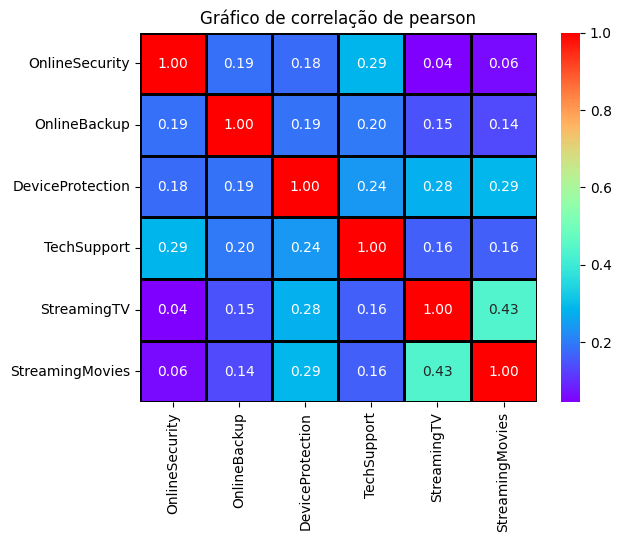

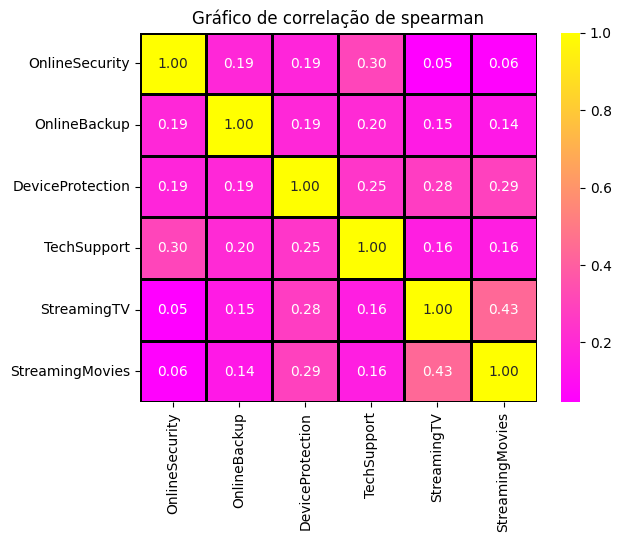

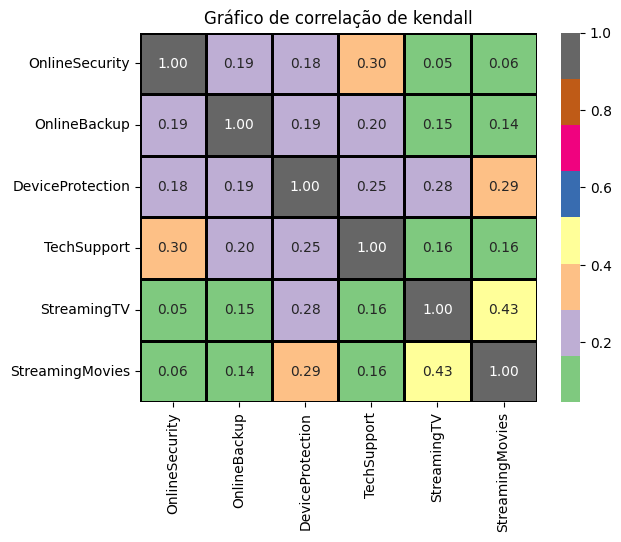

In [16]:
#Vamos visualizar a correlação usando três métodos diferentes para nos certificar de que não estão altamente correlacionadas
cor = correl.corr()
sns.heatmap(cor, annot=True, fmt=".2f", robust=True, cmap="rainbow", linewidths=0.9, linecolor="black").set_title("Gráfico de correlação de pearson")
plt.show()
cor2 = correl.corr(method="spearman")
sns.heatmap(cor2, annot=True, fmt=".2f", robust=True, cmap="spring", linewidths=0.9, linecolor="black").set_title("Gráfico de correlação de spearman")
plt.show()
cor3 = correl.corr(method="kendall")
sns.heatmap(cor3, annot=True, fmt=".2f", robust=True, cmap="Accent", linewidths=0.9, linecolor="black").set_title("Gráfico de correlação de kendall")
plt.show()

In [17]:
#A correlação mais alta que encontramos é entre as colunas 'StreamingTV' e 'StreamingMovies', e embora não seja uma correlação altíssima
#vamos eliminar uma delas para evitar problemas no modelo
churn = churn.drop("StreamingMovies", axis=1)
churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


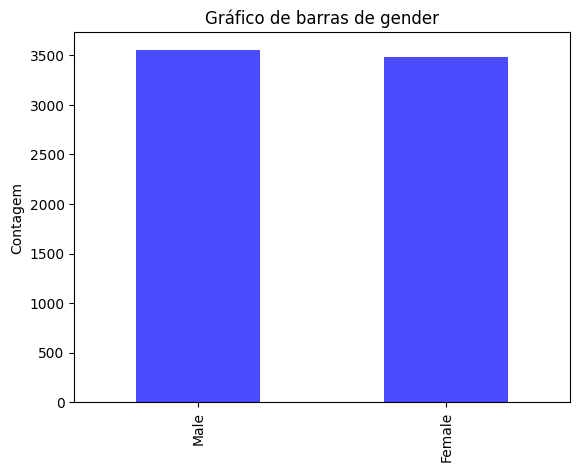

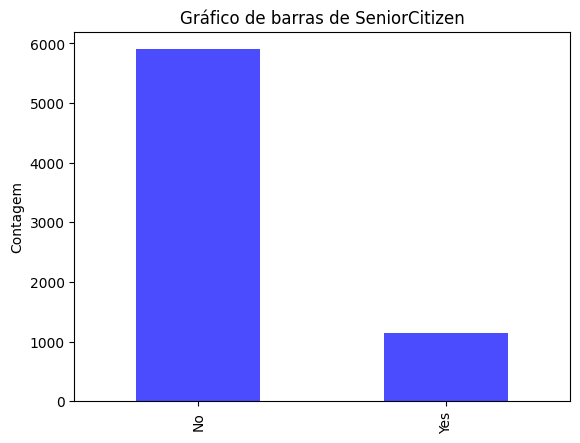

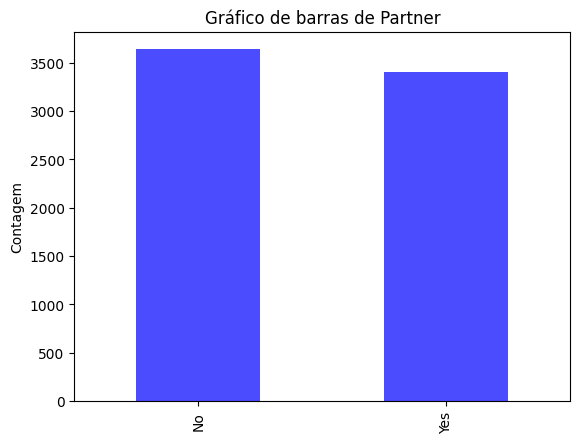

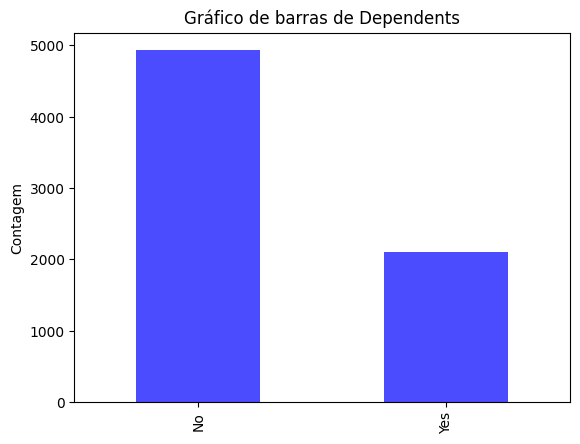

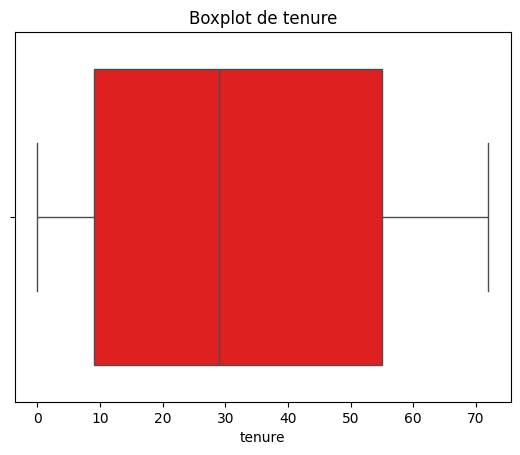

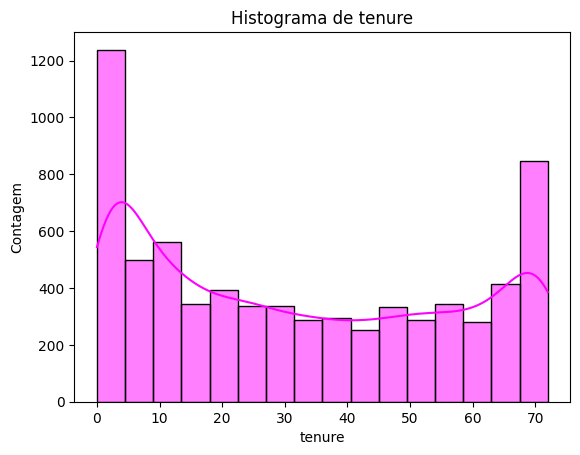

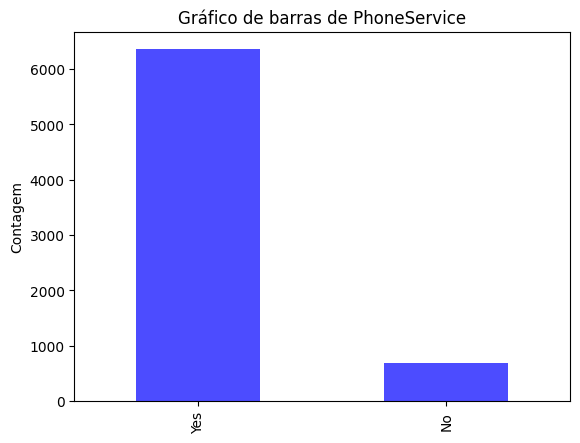

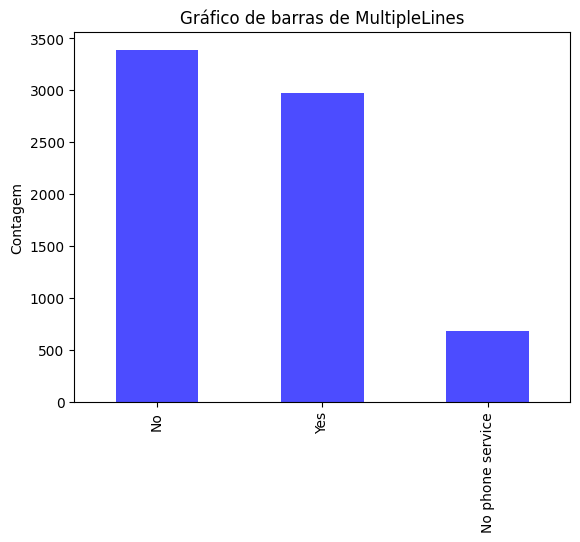

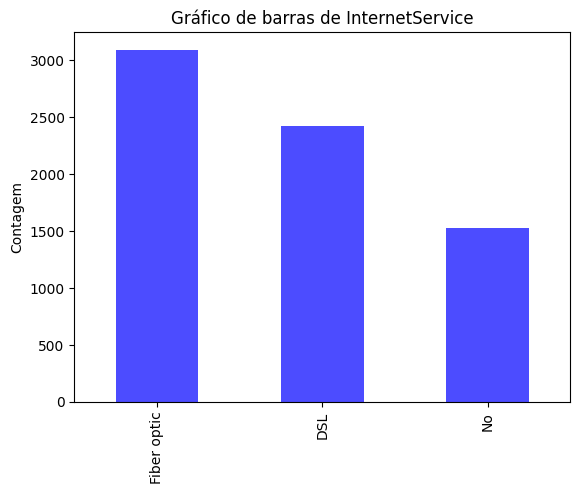

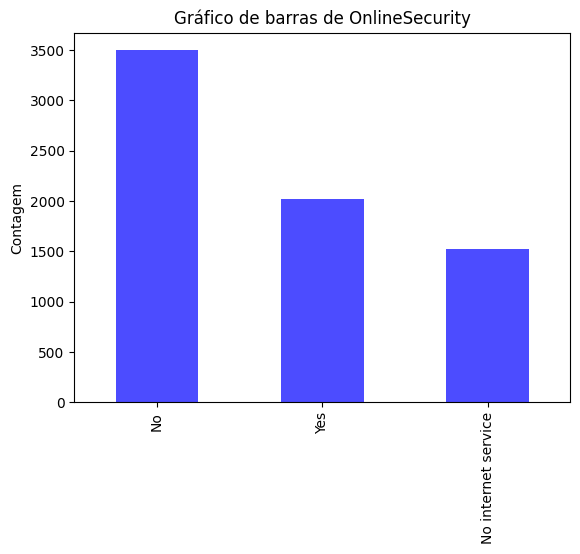

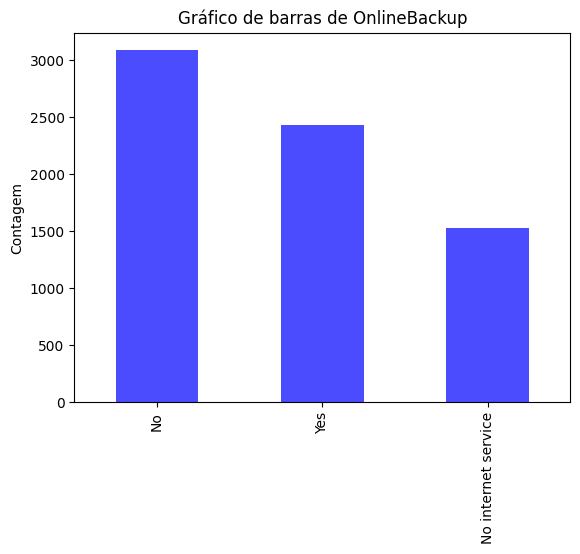

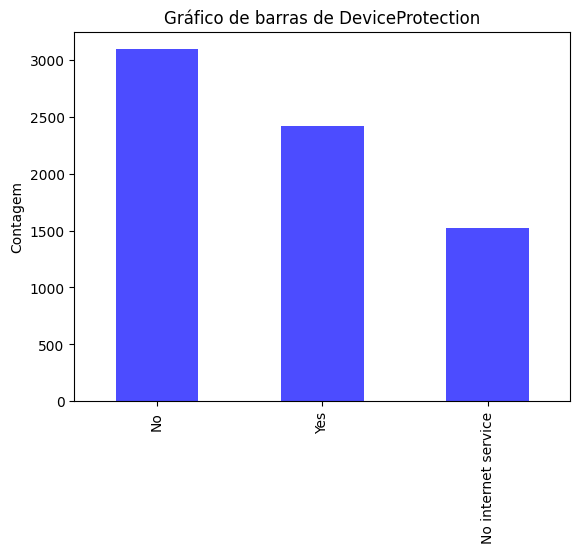

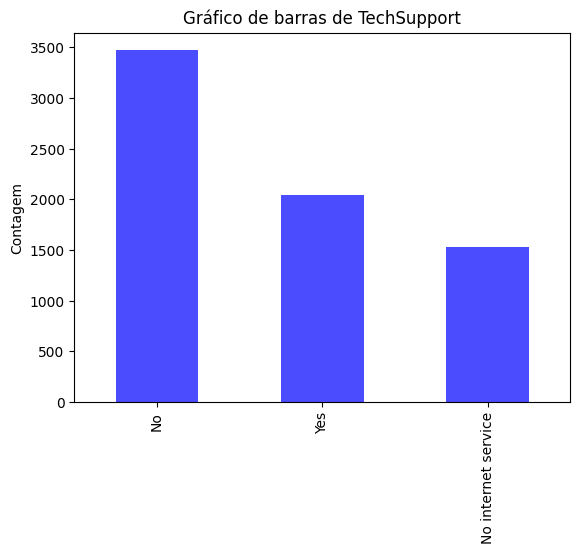

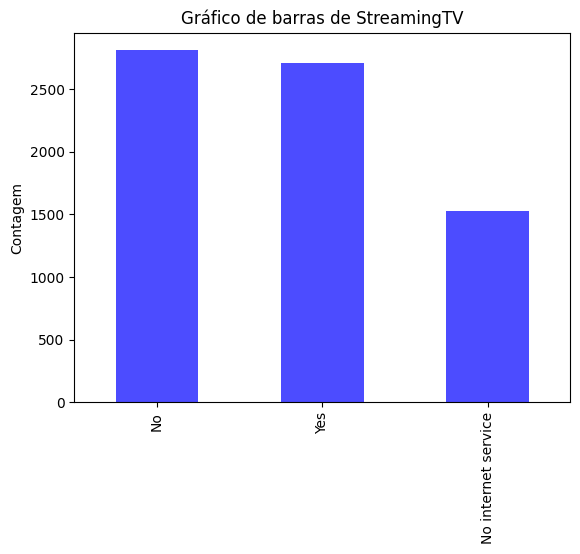

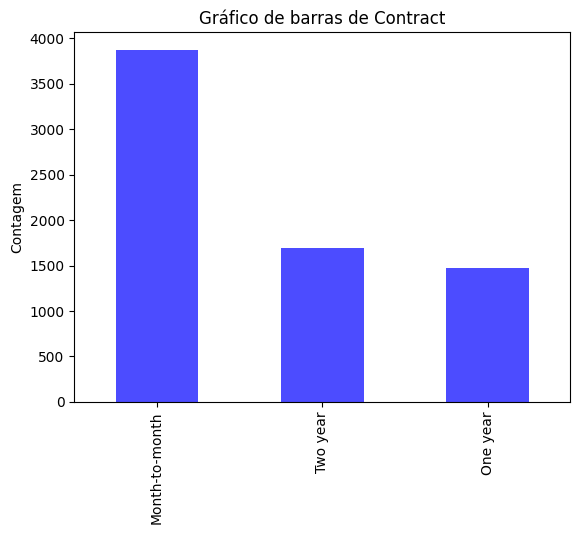

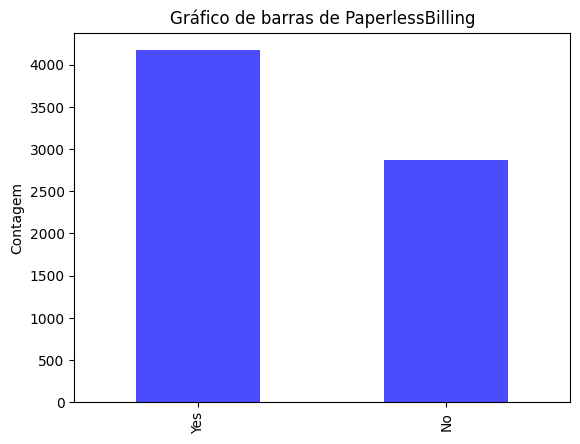

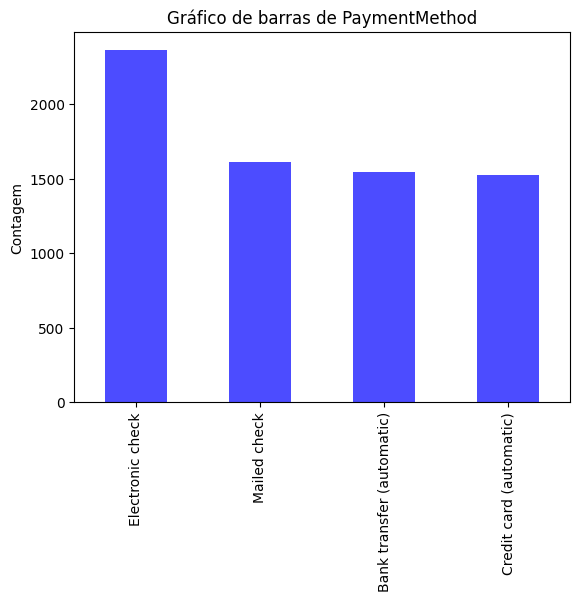

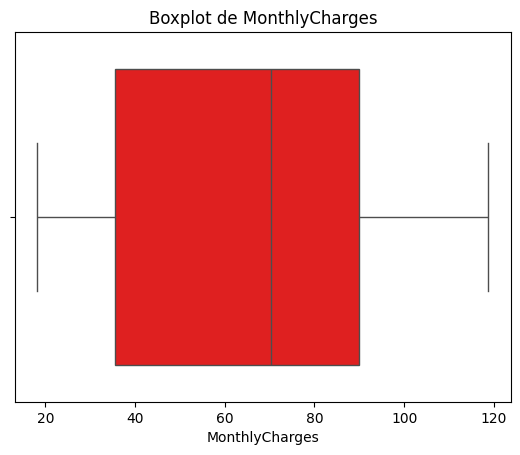

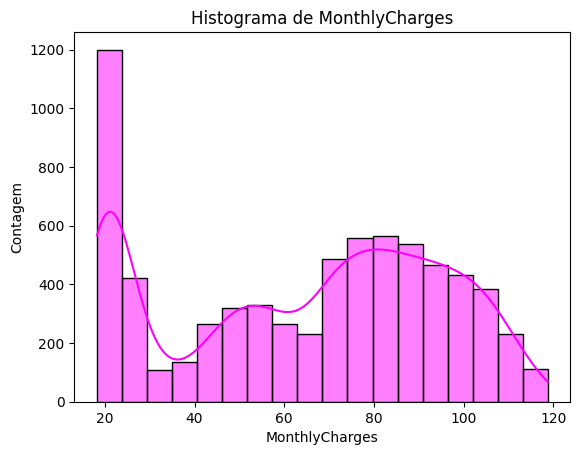

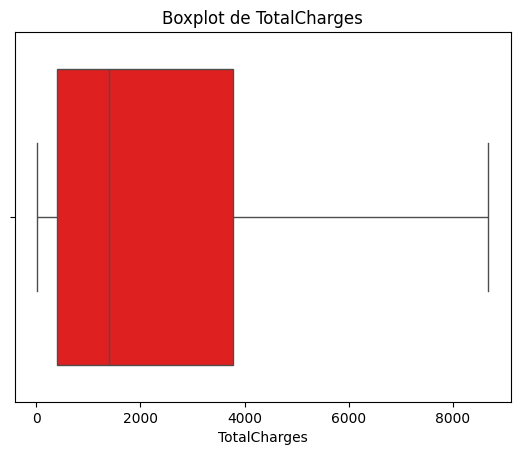

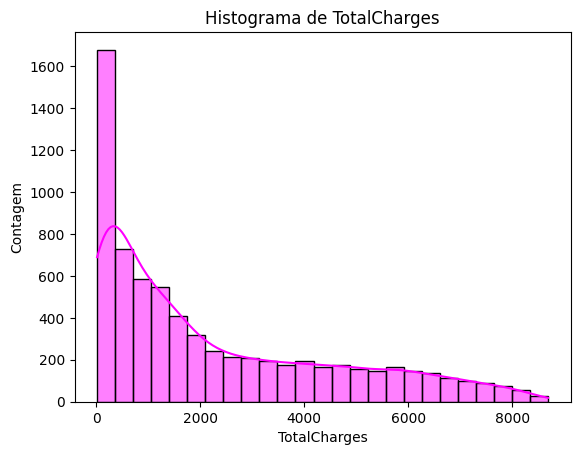

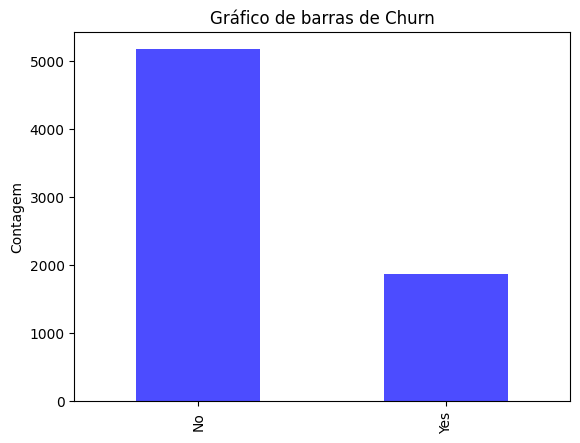

In [18]:
#Vamos visulizar alguns gráficos
for col in churn.columns:
    if churn[col].dtype == "object":
        churn[col].value_counts().plot(kind="bar", alpha=0.7, color = "blue")
        plt.ylabel("Contagem")
        plt.title(f"Gráfico de barras de {col}")
        plt.show()

    else:
        sns.boxplot(data=churn, x=col, orient="horizont", color = "red" ).set_title(f"Boxplot de {col}")
        plt.show()

        sns.histplot(data=churn, x=col, bins="auto", kde=True, color = "magenta" ).set_title(f"Histograma de {col}")
        plt.ylabel("Contagem")
        plt.show()
        
    

Aqui podemos ver que realmente há uma diferença significativa entre as classes

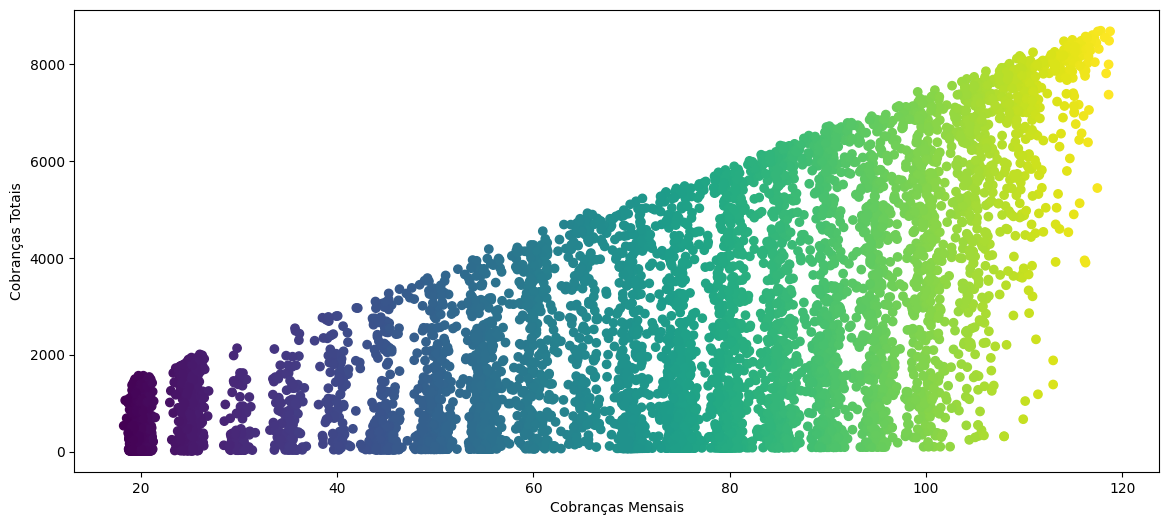

In [19]:
plt.figure(figsize=(14,6))
plt.scatter( churn["MonthlyCharges"], churn["TotalCharges"], c = churn["MonthlyCharges"], cmap = "viridis")
plt.xlabel("Cobranças Mensais")
plt.ylabel("Cobranças Totais")
plt.show()

Aqui vemos uma tendência linear do valor mensal gasto em relação ao valor total

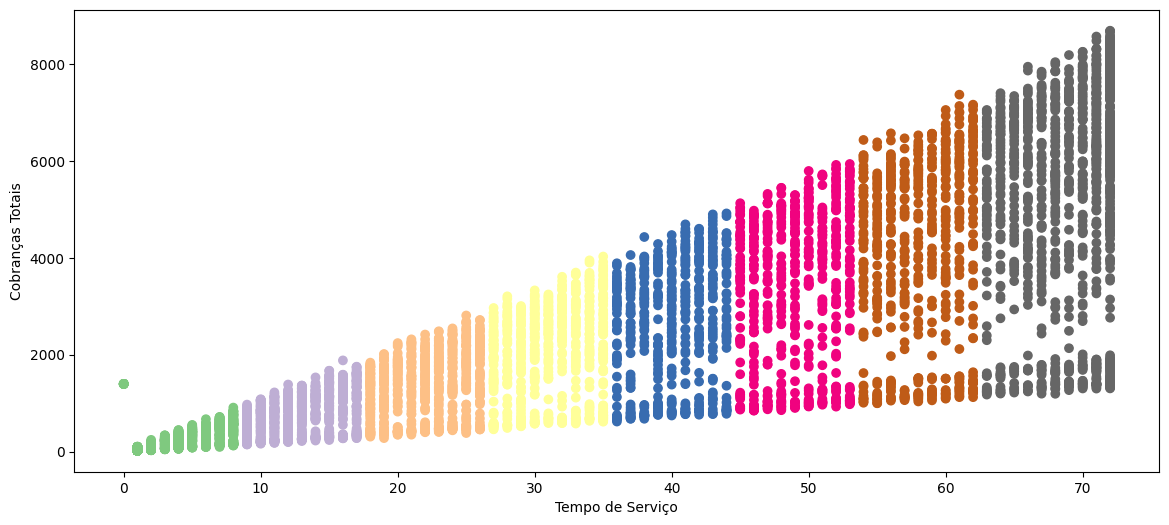

In [20]:
plt.figure(figsize=(14,6))
plt.scatter( churn["tenure"], churn["TotalCharges"], c = churn["tenure"], cmap = "Accent")
plt.xlabel("Tempo de Serviço")
plt.ylabel("Cobranças Totais")
plt.show()

Esses gráficos provavelmente indicam os clientes que estão a mais tempo com a empresa e que tendem a ter uma maior fidelidade e consequentemente gastos na empresa

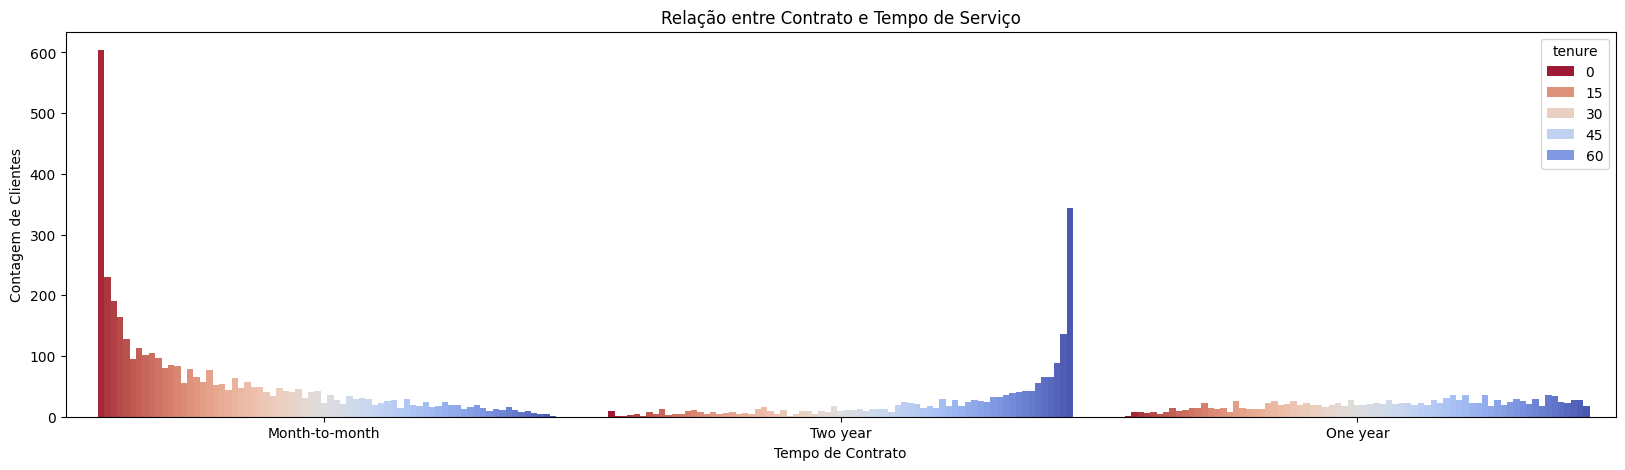

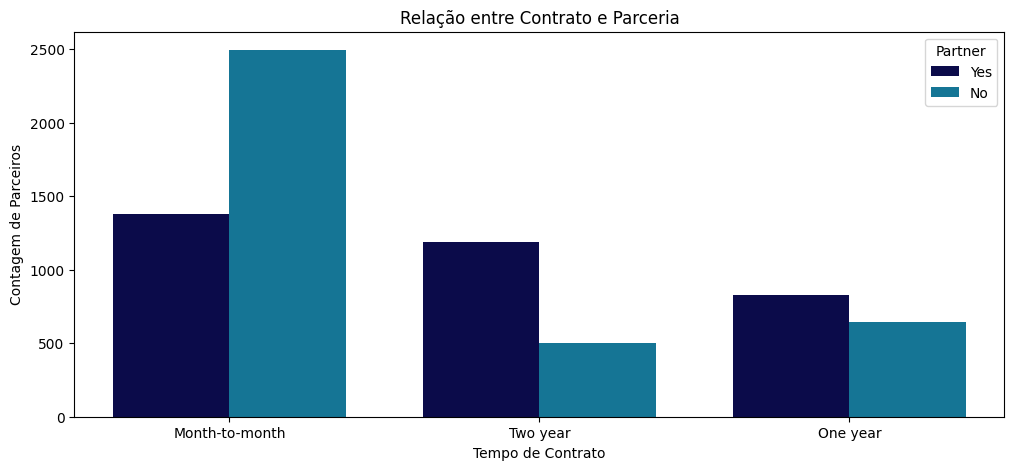

In [53]:
plt.figure(figsize=(20,5))
countplot(churn, x = "Contract", hue = "tenure", order = churn["Contract"].value_counts().index, width = 0.9, palette = "coolwarm_r")
plt.title("Relação entre Contrato e Tempo de Serviço")
plt.xlabel("Tempo de Contrato")
plt.ylabel("Contagem de Clientes")
plt.show()

plt.figure(figsize=(12,5))
countplot(churn, x = "Contract", hue = "Partner", order = churn["Contract"].value_counts().index, width = 0.75, palette = "ocean")
plt.title("Relação entre Contrato e Parceria")
plt.xlabel("Tempo de Contrato")
plt.ylabel("Contagem de Parceiros")
plt.show()

Aqui podemos ver consolidados o tempo de contrato em relação aos parceiros e também em relação ao tempo do cliente na empresa... Podemos ver claramente que clientes
parceiros e com mais tempo na empresa tendem a contratar planos de 1 ou 2 anos o que segundo os modelos influencia fortemente para que os clientes não abandonem a empresa

### Divisão e tratamento final dos dados

In [22]:
#Vamos persistir os dados nesse estado para facilitar a criação do modelo no streamlit
churn.to_csv("dados_tratados.csv", index=False, columns=churn.columns)

In [23]:
#Separação das variáveis independentes e da variável dependente
previsores = churn.drop("Churn", axis=1)
classe = churn["Churn"]
classe[:5]

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

In [24]:
previsores.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [81]:
#Vamos usar 70% dos dados para treino e 30% para teste
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores, classe, test_size=0.3, random_state=1238)
print(X_treinamento.shape)
print(X_teste.shape)

(4930, 18)
(2113, 18)


In [82]:
#Padronização dos dados
scaler = StandardScaler()
numericas = X_treinamento.select_dtypes(include=["float64", "int64"]).columns
X_treinamento[numericas] = scaler.fit_transform(X_treinamento[numericas])
X_treinamento

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6785,Male,No,No,No,1.168914,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),1.560750,2.035383
5069,Female,No,No,No,-1.149296,Yes,Yes,Fiber optic,No,No,No,No,No,Month-to-month,No,Electronic check,0.353897,-0.855167
5476,Female,Yes,No,No,-1.108626,Yes,No,Fiber optic,No,No,Yes,No,Yes,Month-to-month,Yes,Mailed check,0.670175,-0.820925
5541,Female,No,No,No,1.168914,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Two year,Yes,Electronic check,1.394287,1.837468
4084,Female,No,No,No,-1.271307,Yes,No,Fiber optic,No,No,No,No,Yes,Month-to-month,No,Electronic check,0.443786,-0.970140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,Male,No,No,No,-1.271307,Yes,Yes,Fiber optic,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0.565304,-0.968526
6115,Female,No,Yes,Yes,1.616288,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),1.490835,2.468151
3262,Female,No,Yes,Yes,0.070814,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Month-to-month,No,Electronic check,0.756736,0.266068
2786,Male,No,No,Yes,-0.213878,Yes,No,DSL,Yes,Yes,No,No,No,One year,No,Mailed check,-0.283655,-0.311604


In [83]:
#Usando dicionários para guardar os objetos encoders para usá-los posteriormente nos dados de teste
encoders = dict()
for col in X_treinamento.columns:
    encoder = LabelEncoder()
    if X_treinamento[col].dtype=="object":
        X_treinamento[col] = encoder.fit_transform(X_treinamento[col])
        encoders[col] = encoder

X_treinamento[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6785,1,0,0,0,1.168914,1,2,1,2,0,2,2,2,2,1,1,1.560750,2.035383
5069,0,0,0,0,-1.149296,1,2,1,0,0,0,0,0,0,0,2,0.353897,-0.855167
5476,0,1,0,0,-1.108626,1,0,1,0,0,2,0,2,0,1,3,0.670175,-0.820925
5541,0,0,0,0,1.168914,1,2,1,0,0,2,2,2,2,1,2,1.394287,1.837468
4084,0,0,0,0,-1.271307,1,0,1,0,0,0,0,2,0,0,2,0.443786,-0.970140
6525,1,0,1,1,0.924892,1,0,2,1,1,1,1,1,2,0,3,-1.472197,-0.483854
6037,1,1,0,0,1.250254,1,2,1,2,2,2,0,2,0,1,0,1.487506,2.104088
2156,0,0,0,0,-1.230637,1,0,1,0,0,0,0,0,0,0,2,0.527018,-0.923253
3545,0,0,0,0,0.721540,1,2,1,0,0,0,0,2,0,1,2,1.031399,1.086464
3141,1,1,0,0,-1.230637,1,0,1,0,2,2,2,0,0,1,1,1.011423,-0.924955


In [84]:
X_treinamento[numericas] = scaler.fit_transform(X_treinamento[numericas])
X_treinamento.values

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.56074952,  2.03538286],
       [ 0.        ,  0.        ,  0.        , ...,  2.        ,
         0.35389653, -0.85516694],
       [ 0.        ,  1.        ,  0.        , ...,  3.        ,
         0.67017525, -0.82092485],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  2.        ,
         0.75673574,  0.26606813],
       [ 1.        ,  0.        ,  0.        , ...,  3.        ,
        -0.28365477, -0.31160414],
       [ 1.        ,  0.        ,  1.        , ...,  1.        ,
        -0.36855063,  0.67734903]])

In [85]:
for col in X_teste.columns:
    if col in encoders:
        X_teste[col] = encoders[col].transform(X_teste[col])

X_teste.values

array([[1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 3.00000e+00,
        2.61000e+01, 1.85145e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        5.47500e+01, 4.38050e+02],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        4.87000e+01, 2.49520e+03],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        7.10500e+01, 1.52485e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 2.00000e+00,
        6.96500e+01, 2.20100e+02],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 2.00000e+00,
        8.94000e+01, 2.00150e+03]])

In [86]:
#Codificação das Classes
y_encoder = LabelEncoder()
y_treinamento = y_encoder.fit_transform(y_treinamento)
y_teste = y_encoder.transform(y_teste)
y_teste[:10]

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0])

## Treinamento e Avaliação dos Modelos

### XGBClassifier

O primeiro modelo que vamos testar é o XGB passando alguns hiper-parâmetros para teste

In [87]:
seletor = RFE(RandomForestClassifier(class_weight="balanced"), n_features_to_select=10, step=1)
seletor.fit(X_treinamento, y_treinamento)
X_treinamento = seletor.transform(X_treinamento)
X_teste = seletor.transform(X_teste)
X_treinamento.shape

(4930, 10)

In [108]:
seletor.support_

array([ True, False, False, False,  True, False, False,  True,  True,
       False,  True,  True, False,  True, False,  True,  True,  True])

Ranking da Importância de cada Atributo(quanto maior o número menos importante é o atributo)

In [113]:
churn.head(n=1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [112]:
print("Ranking da Importância dos Atributos")
[col for col in zip(seletor.ranking_, churn.columns.drop("Churn"))]

[(1, 'gender'),
 (7, 'SeniorCitizen'),
 (5, 'Partner'),
 (6, 'Dependents'),
 (1, 'tenure'),
 (9, 'PhoneService'),
 (3, 'MultipleLines'),
 (1, 'InternetService'),
 (1, 'OnlineSecurity'),
 (2, 'OnlineBackup'),
 (1, 'DeviceProtection'),
 (1, 'TechSupport'),
 (8, 'StreamingTV'),
 (1, 'Contract'),
 (4, 'PaperlessBilling'),
 (1, 'PaymentMethod'),
 (1, 'MonthlyCharges'),
 (1, 'TotalCharges')]

In [114]:
#Vamos utilizar o GridSearch para seleção dos melhores hiper-parâmetros
xgb = XGBClassifier(scale_pos_weight = 3.5, eval_metric = "aucpr")
params = {"max_depth": [3,5,7,10,20],
         "learning_rate":[0.01,0.05,0.1,0.2,0.3],
         "min_child_weight": [0.5,1,3,5,8],
         "subsample": [0.5,0.75,0.9,1.0],
         "colsample_bytree": [0.5,0.6,0.75,0.9,1.0]}
modelo_xgb = GridSearchCV(xgb, param_grid=params, refit = True, scoring = "f1_weighted", cv=5, return_train_score=True, error_score="raise", n_jobs = -1)
modelo_xgb.fit(X_treinamento, y_treinamento)
print(modelo_xgb.best_params_)

{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 20, 'min_child_weight': 0.5, 'subsample': 0.5}


In [115]:
modelo_xgb.best_score_

0.7783681802245107

In [116]:
best_xgb = modelo_xgb.best_estimator_

Com nossos melhores modelo treinados vamos fazer as previsões e verificar alguma métricas apropriadas

In [117]:
xgb_pred = best_xgb.predict(X_teste)
xgb_pred[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

### Métricas

In [118]:
acuracia = accuracy_score(y_teste, xgb_pred)
print(f"Acurácia: {acuracia}")
print(f"Recall:{recall_score(y_teste, xgb_pred)}")
print(classification_report(y_teste, xgb_pred))

Acurácia: 0.6985328916232845
Recall:0.3513011152416357
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1575
           1       0.40      0.35      0.37       538

    accuracy                           0.70      2113
   macro avg       0.59      0.58      0.59      2113
weighted avg       0.69      0.70      0.69      2113



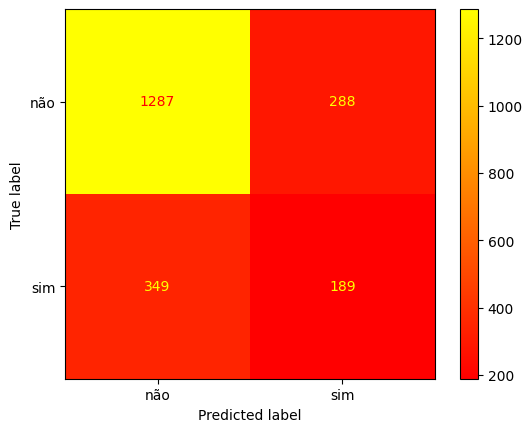

In [119]:
cm = confusion_matrix(y_teste, xgb_pred)
confusion = ConfusionMatrixDisplay(cm, display_labels=["não", "sim"])
confusion.plot(cmap="autumn")

### RandomForest

In [185]:
#Treinamento Florestas Aleatórias
floresta = RandomForestClassifier(class_weight={0:1, 1:3})
params = {
    "n_estimators": [100],
    "max_leaf_nodes": [5,10,20,50],
    "max_depth": [5,7,10,20,50,100],
    "bootstrap": [True, False],
    "max_features":[0.1,0.2],
    "min_samples_leaf":[3,5,7],
    "min_samples_split":[2,5,7]
    }
modelo_random = GridSearchCV(floresta, param_grid=params, refit = True, scoring = "f1_weighted", cv=5, return_train_score=True, error_score="raise", n_jobs = 7)
modelo_random.fit(X_treinamento, y_treinamento)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 3}),
             n_jobs=7,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 7, 10, 20, 50, 100],
                         'max_features': [0.1, 0.2],
                         'max_leaf_nodes': [5, 10, 20, 50],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [100]},
             return_train_score=True, scoring='f1_weighted')

In [179]:
print(modelo_random.best_params_)

{'bootstrap': True, 'max_depth': 10, 'max_features': 0.2, 'max_leaf_nodes': 50, 'min_samples_leaf': 7, 'min_samples_split': 7, 'n_estimators': 100}


In [180]:
print(modelo_random.best_score_)


0.7908628311941828


In [181]:
best_forest = modelo_random.best_estimator_

In [182]:
forest_pred = best_forest.predict(X_teste)
forest_pred

array([0, 0, 0, ..., 0, 1, 1])

### Métricas

In [183]:
acuracia = accuracy_score(y_teste, forest_pred)
print(f"Acurácia: {acuracia}")
print(f"Recall:{recall_score(y_teste, forest_pred)}")
print(classification_report(y_teste, forest_pred))

Acurácia: 0.7998106956933271
Recall:0.4107806691449814
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1575
           1       0.68      0.41      0.51       538

    accuracy                           0.80      2113
   macro avg       0.75      0.67      0.69      2113
weighted avg       0.79      0.80      0.78      2113



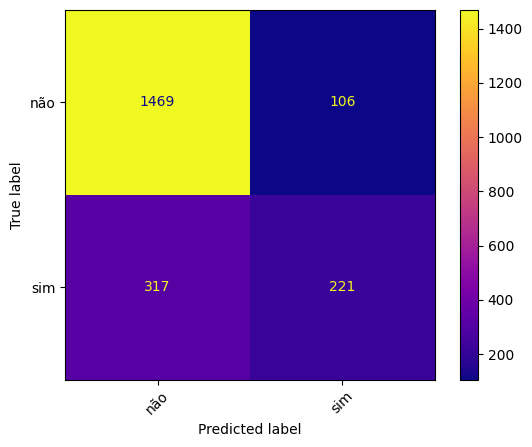

In [184]:
cm = confusion_matrix(y_teste, forest_pred)
confusion = ConfusionMatrixDisplay(cm, display_labels=["não", "sim"])
confusion.plot(cmap="plasma", xticks_rotation=45)

### TPOTClassifier

In [102]:
tpot = TPOTClassifier(generations=200, population_size=200, offspring_size=0.2, mutation_rate=0.8, crossover_rate=0.2,
                         max_time_mins=30, scoring="f1", n_jobs=5, warm_start=False, config_dict="TPOT sparse", verbosity=2)
tpot.fit(X_treinamento, y_treinamento)

                                                                              
Best pipeline: BernoulliNB(XGBClassifier(input_matrix, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.1, verbosity=0), alpha=1.0, fit_prior=False)


TPOTClassifier(config_dict='TPOT sparse', crossover_rate=0.2, generations=200,
               max_time_mins=30, mutation_rate=0.8, n_jobs=5,
               offspring_size=0.2, population_size=200, scoring='f1',
               verbosity=2)

In [103]:
tpot_pred = tpot.predict(X_teste)
tpot_pred[:10]

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

### Métricas

In [104]:
acuracia = accuracy_score(y_teste, tpot_pred)
print(f"Acurácia: {acuracia}")
print(f"Recall:{recall_score(y_teste, tpot_pred)}")
print(classification_report(y_teste, tpot_pred))

Acurácia: 0.7657359204921912
Recall:0.5910780669144982
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1575
           1       0.54      0.59      0.56       538

    accuracy                           0.77      2113
   macro avg       0.70      0.71      0.70      2113
weighted avg       0.77      0.77      0.77      2113



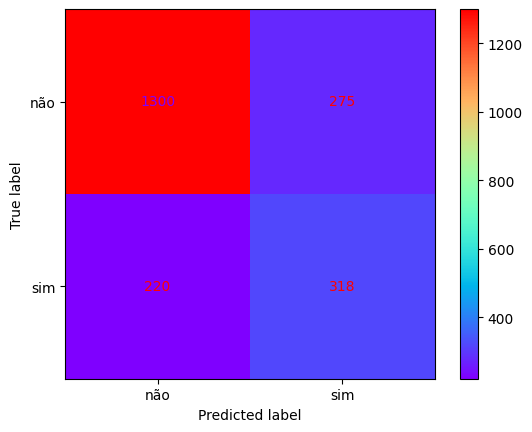

In [105]:
cm = confusion_matrix(y_teste, tpot_pred)
confusion = ConfusionMatrixDisplay(cm, display_labels=["não", "sim"])
confusion.plot(cmap="rainbow")

## Conclusão

Após executados vários testes com os modelos temos o melhor modelo com os melhores parâmetros ajustados...
Agora vamos treinar o novamente, validar e disponibilizar o modelo para previsões usando o streamlit.. 
Também iremos implementar outras funcionalidades como explicabilidade e algumas análises exploratórias dos dados

### Melhorias futuras - Versão 2.0

Para uma futura versão melhorada podemos buscar uma melhoria nos hiperparâmetros do nosso modelo assim como teste de outros algoritmos como autoMl, por exemplo, para busca de uma otimização
nas métricas do modelo que obteve uma boa generalização com os dados de teste e já é satisfatório chegando próximo á 80%, o que é suficiente para nosso propósito

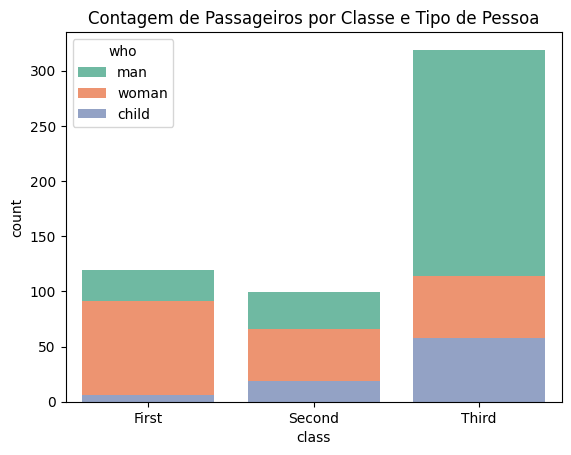

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dados de exemplo
df = sns.load_dataset('titanic')

# Countplot com vários parâmetros
sns.countplot(
    x='class', 
    hue='who', 
    data=df, 
    order=['First', 'Second', 'Third'],
    palette='Set2', 
    dodge=False, 
    saturation=0.8
)

plt.title('Contagem de Passageiros por Classe e Tipo de Pessoa')
plt.show()
